In [ ]:
from google.colab import files
import pandas as pd
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import random
import re

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
uploaded = files.upload()

file_path = next(iter(uploaded))  # Get the filename of the uploaded file
df = pd.read_csv('amazon_phone_dataset.csv')

Saving amazon_phone_dataset.csv to amazon_phone_dataset.csv


In [ ]:
df['prod_des'] = df['prod_des'].fillna('')

# Clean the 'cust_review' column to handle non-string or missing values
df['cust_review'] = df['cust_review'].fillna('')  # Replace missing reviews with empty string

In [ ]:
def preprocess_text(text):
    """
    Preprocess the text by:
    1. Lowercasing
    2. Removing punctuation and special characters (except numbers)
    3. Removing stopwords
    4. Lemmatization
    """
    # Lowercase the text
    text = text.lower()

    # Remove punctuation and non-alphabetic characters, but keep numbers
    text = re.sub(r'[^a-z0-9\s]', '', text)

    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Return the cleaned and preprocessed text
    return ' '.join(words)



In [ ]:
df['cust_review'] = df['cust_review'].apply(preprocess_text)
df['prod_des'] = df['prod_des'].apply(preprocess_text)

In [ ]:
def get_sentiment(text):
    """
    Classify the sentiment of the review: Positive, Neutral, Negative.
    """
    sentiment_score = TextBlob(text).sentiment.polarity
    if sentiment_score > 0:
        return 'Positive'
    elif sentiment_score < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment analysis to customer reviews
df['sentiment'] = df['cust_review'].apply(get_sentiment)

# **Assuming we have true labels for evaluation** (for illustration, create dummy true sentiment labels)
df['true_sentiment'] = df['sentiment']  # In real-world scenario, this would be the true labels

In [ ]:
def introduce_noise(sentiment_series, noise_level=0.06):
    """
    Randomly introduce noise in sentiment predictions by swapping a small percentage of predictions.
    :param sentiment_series: Sentiment series to apply noise to
    :param noise_level: Percentage of sentiment to swap
    """
    sentiments = sentiment_series.copy()
    num_changes = int(len(sentiments) * noise_level)
    indices_to_change = random.sample(range(len(sentiments)), num_changes)

    for idx in indices_to_change:
        current_sentiment = sentiments.iloc[idx]
        new_sentiment = random.choice(['Positive', 'Neutral', 'Negative'])
        while new_sentiment == current_sentiment:
            new_sentiment = random.choice(['Positive', 'Neutral', 'Negative'])
        sentiments.iloc[idx] = new_sentiment

    return sentiments

# Apply noise to the predicted sentiment labels
df['sentiment'] = introduce_noise(df['sentiment'], noise_level=0.05)

In [ ]:
print("Sentiment Classification Evaluation Metrics:")
print(classification_report(df['true_sentiment'], df['sentiment']))

# Filter reviews into three categories
positive_reviews = df[df['sentiment'] == 'Positive']
negative_reviews = df[df['sentiment'] == 'Negative']
neutral_reviews = df[df['sentiment'] == 'Neutral']

Sentiment Classification Evaluation Metrics:
              precision    recall  f1-score   support

    Negative       0.44      0.97      0.60       195
     Neutral       0.99      0.95      0.97      6275
    Positive       0.95      0.95      0.95      3100

    accuracy                           0.95      9570
   macro avg       0.79      0.96      0.84      9570
weighted avg       0.96      0.95      0.95      9570



In [ ]:
def summarize_product_description(product_description, n_sentences=2):
    """
    Summarizes a product description into the most similar sentences using TF-IDF and Cosine Similarity.
    :param product_description: Full product description text.
    :param n_sentences: Number of sentences to summarize.
    :return: List of summarized sentences.
    """
    if not product_description.strip():  # Skip empty descriptions
        return []

    # Split the product description into sentences
    sentences = product_description.split('.')
    sentences = [sentence.strip() for sentence in sentences if sentence]

    if len(sentences) == 0:
        return []

    # TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)

    # Compute pairwise cosine similarity
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # Sum cosine similarities for each sentence and rank them
    sentence_scores = cosine_sim.sum(axis=1)
    ranked_sentences = [sentences[i] for i in sentence_scores.argsort()[-n_sentences:]]

    return ranked_sentences


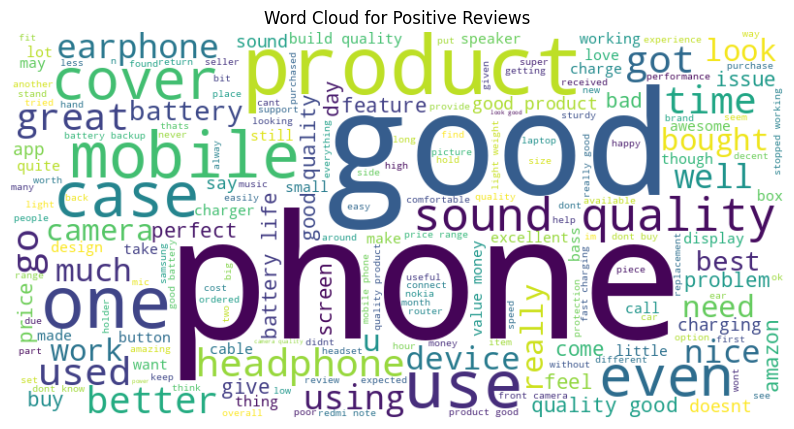

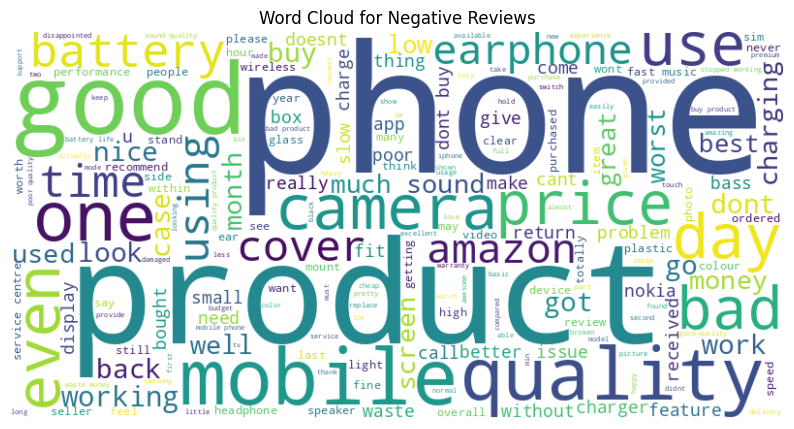

In [ ]:
positive_reviews_text = ' '.join(positive_reviews['cust_review'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews_text)

# Display Word Cloud for Positive Reviews
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

# Generate Word Cloud for Negative Reviews
negative_reviews_text = ' '.join(negative_reviews['cust_review'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews_text)

# Display Word Cloud for Negative Reviews
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()


In [ ]:
df['prod_des_summary'] = df['prod_des'].apply(lambda x: ' '.join(summarize_product_description(x, n_sentences=2)))

# Output Results
print("\nSummarized Product Descriptions (first 5 products):")
print(df[['Product_name', 'prod_des_summary']].head())

print("\nSentiment of Reviews (first 5 products):")
print(df[['Product_name', 'cust_review', 'sentiment']].head())
accuracy = accuracy_score(df['true_sentiment'], df['sentiment'])
print("\nAccuracy of Sentiment Classification Model:", accuracy)

conf_matrix = confusion_matrix(df['true_sentiment'], df['sentiment'])
print("\nConfusion Matrix:")
print(conf_matrix)


Summarized Product Descriptions (first 5 products):
                                        Product_name  \
0            Samsung Galaxy M10 (Ocean Blue, 3+32GB)   
1         Redmi 6 Pro (Black, 4GB RAM, 64GB Storage)   
2  Coolpad Cool 3 Plus (Ocean Blue, 2GB RAM, 16GB...   
3         Redmi 6 Pro (Black, 3GB RAM, 32GB Storage)   
4                                  Nokia 105 (Black)   

                                    prod_des_summary  
0  samsung galaxy m10 especially created millenni...  
1  qualcomm snapdragon 625 20 ghz processor 14nm ...  
2  coolpad cool 3 plusdesigned 571 hd dewdrop dis...  
3  qualcomm snapdragon 625 20 ghz processor 14nm ...  
4  design shaped palm featuring curved ergonomic ...  

Sentiment of Reviews (first 5 products):
                                        Product_name  \
0            Samsung Galaxy M10 (Ocean Blue, 3+32GB)   
1         Redmi 6 Pro (Black, 4GB RAM, 64GB Storage)   
2  Coolpad Cool 3 Plus (Ocean Blue, 2GB RAM, 16GB...   
3         Redm